In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm

from scipy.spatial import distance_matrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import torch
from sklearn import metrics
import xgboost as xgb 

from data import DataGatherer
import params
# from test import encode_data
from models import load_model

/srv/public/Thibaud/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/srv/public/Thibaud/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
param_dic = params.__get_dict__()
print(param_dic["data_spliting"])

{'additional_samples': 0,
 'augmentations': ['addSomeNoise'],
 'batch_size': 32,
 'class_hidden_size': 256,
 'class_layers_nb': 1,
 'conv_features1_nb': 80,
 'conv_features2_nb': 30,
 'conv_kernel1_size': 15,
 'conv_kernel2_size': 5,
 'conv_layers_nb': 4,
 'convm_embedding_size': 128,
 'convm_kernel_size': 25,
 'convm_layer_nb': 10,
 'convm_out_size': 32,
 'convm_patch_size': 10,
 'data_limit': -1,
 'data_spliting': 'pos_split',
 'data_test_rate': 0.05,
 'data_type': 'not_complex',
 'data_use_position': False,
 'datafile': '/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.raw.3_data.npy',
 'device': 'cuda',
 'dropout_value': 0,
 'expender_hidden_size': 256,
 'expender_layers_nb': 1,
 'expender_out': 256,
 'feature_norm': 'layer',
 'flat_data': True,
 'implied_values': <function implied_values at 0x7f0afdf9fa30>,
 'input_type': 'spectrogram',
 'labelfile': '/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.raw.3_labels.npy',
 'lambda_class': 1,
 'lambda_cov': 4,
 'lambda_

In [3]:
# data = np.load("/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.2.3_data.npy")
# label = np.load("/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.2.3_labels.npy")

data = np.load("/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.raw.3_data.npy")
label = np.load("/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.raw.3_labels.npy")


num_classes = max(label[:, 0]) + 1
num_positions = max(label[:, 1]) + 1
print(num_classes, num_positions)

13 50


In [4]:
# dg = DataGatherer()
# trainDataloader, valDataloader = dg.spliting_data()

In [63]:
# params.input_type = "none"
# params.conv_layers_nb = 3
# params.tail_fc_layers_nb = 1
# params.class_layers_nb = 2
# params.batch_size = 1024
# params.conv_features1_nb = 10
# params.conv_features2_nb = 10
# params.conv_kernel1_size = 15
# params.conv_kernel2_size = 6
# params.stride_size = 1
# params.conv_layers_nb = 3
# params.class_layers_nb = 2
# params.class_hidden_size = 64
# params.tail_fc_layers_nb = 1
# params.pooling_kernel_size = 2
# params.pooling_stride_size = 2
# params.expender_out= 138
# params.latent_dimention= 32
# params.padding_size= 1
# params.signal_length= 200

# model = torch.load("../data/model_model_cnn_accurate_11dev_46pos_500.pth")
model = torch.load("../data/model_model_trans_accurate_11dev_46pos_125.pth")

In [64]:
from data import MyDataset, MyDataLoader


params.data_test_rate = 0.1
params.batch_size = 256
params.spectrogram_window_size = 32

def encode_data(mymodel, this_data, this_labels):

    z = list(zip(this_data, this_labels))
    loader = MyDataLoader(MyDataset(z))

    mymodel.eval()
    encs, labs = [], []
    count = 0
    amt2encode = len(loader.dataset) * params.data_test_rate
    for i, (batchX, batchY) in enumerate(loader):
        # Compute encoded version of the data by our embedding model
        encs = encs + mymodel.encode(batchX).tolist()
        # Gather device labels accordingly (eventually randomly enumerated)
        labs = labs + batchY.tolist()
        count += batchX.shape[0]
        if count > amt2encode:
            break
    return encs, labs

In [65]:
encoded_data, encoded_labels = encode_data(model, data, label)
# encoded_data = np.random.rand(50000, 350)
# random_dev_label = np.expand_dims(np.random.choice(13, size=50000), axis=1)
# random_pos_label = np.expand_dims(np.random.choice(50, size=50000), axis=1)

# encoded_labels = np.concatenate((random_dev_label, random_pos_label), axis=1)
# print(encoded_data.shape, encoded_labels.shape)

print("Size of the sub_set of encoded points: ", len(encoded_data))


Size of the sub_set of encoded points:  77152


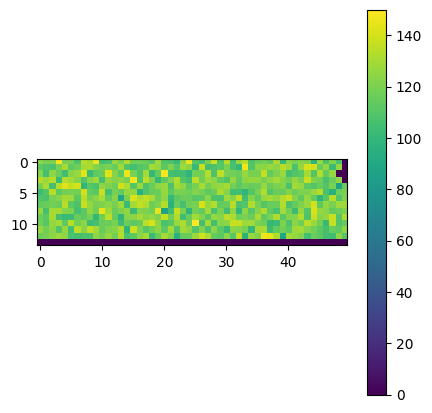

In [66]:
# SEE WHERE IS WHAT
cleaner_labels = np.array(encoded_labels)

pos_ids = [np.where(cleaner_labels[:,1] == i) for i in range(50)]
dev_ids = [np.where(cleaner_labels[:,0] == i) for i in range(14)]

m = []
for dev in range(14):
    m.append([])
    for pos in range(50):
        ids = list(set(dev_ids[dev][0]) & set(pos_ids[pos][0]))
        m[dev].append(len(ids))

m = np.array(m)
plt.imshow(m)
plt.colorbar()
plt.show()

# To do to try

- XGBoost classify the encoded values
- Code a little Re-Identification setup on the test+train data
    - Basic anchor + distance to anchor seting (no need to update)
- Vote on n sample of same device elements (does it improve from accuracy ?)
- Estimate the time to encode + computational needs
- Try isolated device from train to reid between all positions
- Try multiple unseen positions if they match one to another
- Do a study of capabilities according to the amount of data available and it's cleaness

In [67]:
# Plotting
def scatter_plot(X, Y):
        dimentions = [[2*i, i*2+1] for i in range(1)]
        colors_base = cm.rainbow(np.linspace(0, 1, num_classes))
        plt.rcParams["figure.figsize"] = (5,5)
        cmap, norm = matplotlib.colors.from_levels_and_colors(np.arange(0, num_classes+1)- 0.5, colors_base)

        print(X.shape)
        print(Y.shape)

        for i in range(len(dimentions)):
                fig, ax = plt.subplots()
                scatter = ax.scatter(X[:, dimentions[i][0]], X[:, dimentions[i][1]], c=Y, norm=norm, cmap=cmap, marker=".", linewidths=0.5, s=25)
                handles, lab = scatter.legend_elements(prop="colors", num=num_classes, alpha=0.6)
                legend1 = ax.legend(handles, lab,
                        loc="lower left", title="Device id")
                ax.add_artist(legend1)
                ax.set_title("dimentions " + str(i*2) + "and " + str(i*2+1))
                # .legend(loc='upper left',prop = {'size':7},bbox_to_anchor=(1,1))
                # plt.tight_layout(pad=5)
                plot_img = "data/plot_"+str(i)+".png"
        return fig

(77152, 384) (77152, 2)
(7715, 384)
(7715,)


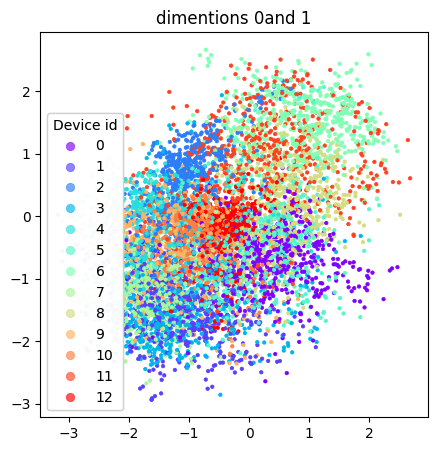

In [68]:
encoded_data = np.array(encoded_data)
encoded_labels = np.array(encoded_labels)

print(encoded_data.shape, encoded_labels.shape)

r = np.random.choice(len(encoded_data), size=len(encoded_data)//10, replace=False)
scatter_plot(np.array(encoded_data)[r], np.array(encoded_labels)[r][:, 0])
plt.show()

In [69]:
def compute_anchors(this_data, this_labels):
    centroids = []
    for dev in set(this_labels):
        ids_dev = np.where(np.array(this_labels) == dev)[0]
        class_encoded = np.array(this_data)[ids_dev]
        # Should this be a euclidien mean value ??
        centroids.append(class_encoded.mean(axis=0))

    centroids = np.array(centroids)
    print(centroids.shape)

    return centroids

def get_reid_prediction(anchors, this_data, anchor_labels):
    set_labels = list(set(anchor_labels))
    distances_centers = distance_matrix(this_data, anchors)
    predicted_id = np.argmin(distances_centers, axis=1)
    predicted_class = list(map(lambda x: set_labels[x], predicted_id))
    return predicted_class

# The evaluations

In [70]:
def re_id_report(anchors_ids, query_ids):

    print("***************")
    print("RE-ID PROTOCOLE")
    print("***************")

    # Compile the re-identification process accuracy
    query_labels = encoded_labels[query_ids][:, 0]
    anchor_labels = encoded_labels[anchors_ids][:, 0]
    anchors = compute_anchors(encoded_data[anchors_ids], anchor_labels)
    print("Number of anchors: ", len(anchors))
    query_predictions = get_reid_prediction(anchors, encoded_data[query_ids], anchor_labels)

    print('confusion matrix')
    conf_mx =confusion_matrix(query_labels, query_predictions)
    # print(conf_mx)

    # Confusion Matrix Display
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                                display_labels=set(query_labels))
    disp.plot()
    plt.show()

    print('classification_report')
    print(classification_report(query_labels, query_predictions))

In [71]:
def clustering_evaluation(anchors_ids, query_ids):
    query_labels = encoded_labels[query_ids][:, 0]
    anchor_labels = encoded_labels[anchors_ids][:, 0]
    querys = encoded_data[query_ids]
    anchors = encoded_data[anchors_ids]

    sil_score = metrics.silhouette_score(querys, query_labels)
    ch_score = metrics.calinski_harabasz_score(querys, query_labels)
    db_score = metrics.davies_bouldin_score(querys, query_labels)

    print("***********************")
    print("SOME CLUSTERING METRICS")
    print("***********************")


    print("Query clustering scores: ", )
    print("Silhouette score in [-1, 1] - ", sil_score)
    print("Calinski Harabasz score [relative] - ", ch_score)
    print("Davies Bouldin score [lower the better] - ", db_score)

In [72]:
def xgboost_evaluation(anchors_ids, query_ids):
    query_labels = encoded_labels[query_ids][:, 0]
    anchor_labels = encoded_labels[anchors_ids][:, 0]
    querys = encoded_data[query_ids]
    anchors = encoded_data[anchors_ids]

    xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

    xgb_model.fit(anchors, anchor_labels)

    predicted_class = xgb_model.predict(querys)
    print("*****************************")
    print("XGB CLASSIFICATION EVALUATION")
    print("*****************************")

    print('confusion matrix')
    conf_mx =confusion_matrix(query_labels, predicted_class)
    # print(conf_mx)

    # Confusion Matrix Display
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                                display_labels=set(query_labels))
    disp.plot()
    plt.show()


    print('classification_report')
    print(classification_report(query_labels, predicted_class))

# Preparing eval data

In [73]:
validation_dev = list(range(11))
validation_pos = [5]

training_dev = list(range(11))
training_pos = [i for i in range(46) if not i in validation_pos]

test_dev = list(range(13)) #[11, 12]
test_pos = [46, 47]

print(training_pos)

dev_ids = [np.where(encoded_labels[:,0] == i) for i in range(14)]
pos_ids = [np.where(encoded_labels[:,1] == i) for i in range(50)]

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]


In [74]:
train_ids = []
val_ids = []
test_ids = []
scenario2_anchors_ids = []
scenario2_query_ids = []
scenario3_anchors_ids = []
scenario3_query_ids = []
for dev in range(len(dev_ids)):
    for pos in range(len(pos_ids)): 
        inter_ids = list(set(dev_ids[dev][0]) & set(pos_ids[pos][0]))   
        # Base separation
        if dev in training_dev and pos in training_pos :
            train_ids = train_ids + inter_ids
            # # Also add distractors to scenario 3
            # scenario3_anchors_ids = scenario3_anchors_ids + inter_ids
        elif dev in validation_dev and pos in validation_pos :
            val_ids = val_ids + inter_ids
            # # Also add distractors to scenario 3
            # scenario3_anchors_ids = scenario3_anchors_ids + inter_ids
        elif dev in test_dev and pos in test_pos :
            test_ids = test_ids + inter_ids
            # Scenario 3 specific
            if pos == test_pos[0]:
                scenario3_anchors_ids = scenario3_anchors_ids + inter_ids
            else :
                scenario3_query_ids = scenario3_query_ids + inter_ids

        else :
            assert("what is this unclassified data:{:1f}, {:1f}".format(dev, pos))

        # Transversal separation
        if dev in validation_dev and pos in test_pos :  # Seen devices and 2 unseen positions
            if pos == test_pos[0]:
                scenario2_anchors_ids = scenario2_anchors_ids + inter_ids
            else :
                scenario2_query_ids = scenario2_query_ids + inter_ids


In [75]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

59340
1340
3016


## Scenario 1
Devices and Position from the training set

***************
RE-ID PROTOCOLE
***************
(11, 384)
Number of anchors:  11
confusion matrix


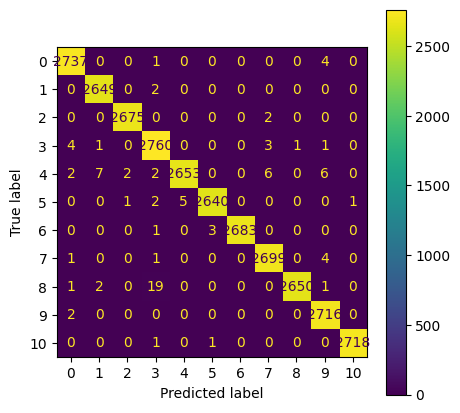

classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2742
           1       1.00      1.00      1.00      2651
           2       1.00      1.00      1.00      2677
           3       0.99      1.00      0.99      2770
           4       1.00      0.99      0.99      2678
           5       1.00      1.00      1.00      2649
           6       1.00      1.00      1.00      2687
           7       1.00      1.00      1.00      2705
           8       1.00      0.99      1.00      2673
           9       0.99      1.00      1.00      2718
          10       1.00      1.00      1.00      2720

    accuracy                           1.00     29670
   macro avg       1.00      1.00      1.00     29670
weighted avg       1.00      1.00      1.00     29670

***********************
SOME CLUSTERING METRICS
***********************
Query clustering scores: 
Silhouette score in [-1, 1] -  0.3754014004335133
Calinski Harabasz

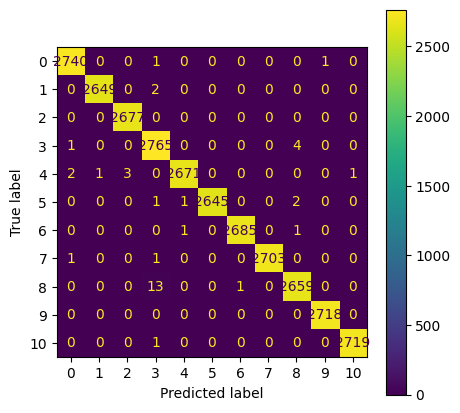

classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2742
           1       1.00      1.00      1.00      2651
           2       1.00      1.00      1.00      2677
           3       0.99      1.00      1.00      2770
           4       1.00      1.00      1.00      2678
           5       1.00      1.00      1.00      2649
           6       1.00      1.00      1.00      2687
           7       1.00      1.00      1.00      2705
           8       1.00      0.99      1.00      2673
           9       1.00      1.00      1.00      2718
          10       1.00      1.00      1.00      2720

    accuracy                           1.00     29670
   macro avg       1.00      1.00      1.00     29670
weighted avg       1.00      1.00      1.00     29670



In [76]:
np.random.shuffle(train_ids)
anchors_ids = train_ids[:len(train_ids)//2]
query_ids = train_ids[len(train_ids)//2:]

re_id_report(anchors_ids, query_ids)
clustering_evaluation(anchors_ids, query_ids)
xgboost_evaluation(anchors_ids, query_ids)

## Scenario 2
All train devices in unknown position

11 Devices in 2 positions

***************
RE-ID PROTOCOLE
***************
(11, 384)
Number of anchors:  11
confusion matrix


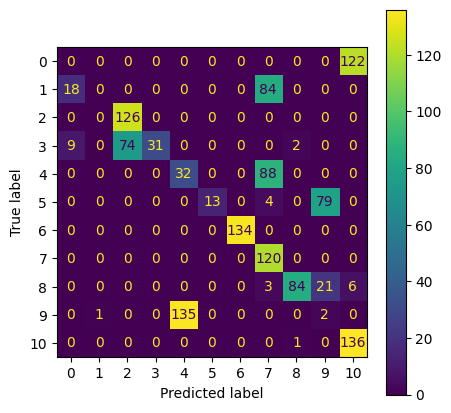

classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       122
           1       0.00      0.00      0.00       102
           2       0.63      1.00      0.77       126
           3       1.00      0.27      0.42       116
           4       0.19      0.27      0.22       120
           5       1.00      0.14      0.24        96
           6       1.00      1.00      1.00       134
           7       0.40      1.00      0.57       120
           8       0.97      0.74      0.84       114
           9       0.02      0.01      0.02       138
          10       0.52      0.99      0.68       137

    accuracy                           0.51      1325
   macro avg       0.52      0.49      0.43      1325
weighted avg       0.51      0.51      0.44      1325

***********************
SOME CLUSTERING METRICS
***********************
Query clustering scores: 
Silhouette score in [-1, 1] -  0.46402486614015237
Calinski Harabas

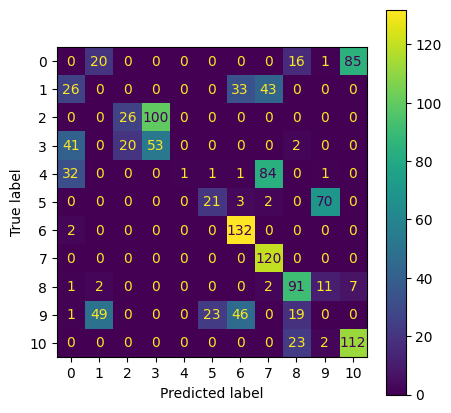

classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       122
           1       0.00      0.00      0.00       102
           2       0.57      0.21      0.30       126
           3       0.35      0.46      0.39       116
           4       1.00      0.01      0.02       120
           5       0.47      0.22      0.30        96
           6       0.61      0.99      0.76       134
           7       0.48      1.00      0.65       120
           8       0.60      0.80      0.69       114
           9       0.00      0.00      0.00       138
          10       0.55      0.82      0.66       137

    accuracy                           0.42      1325
   macro avg       0.42      0.41      0.34      1325
weighted avg       0.42      0.42      0.35      1325



In [77]:
anchors_ids = scenario2_anchors_ids
query_ids = scenario2_query_ids

re_id_report(anchors_ids, query_ids)
clustering_evaluation(anchors_ids, query_ids)
xgboost_evaluation(anchors_ids, query_ids)

## Scenario 3
Devices and position unknown

***************
RE-ID PROTOCOLE
***************
(13, 384)
Number of anchors:  13
confusion matrix


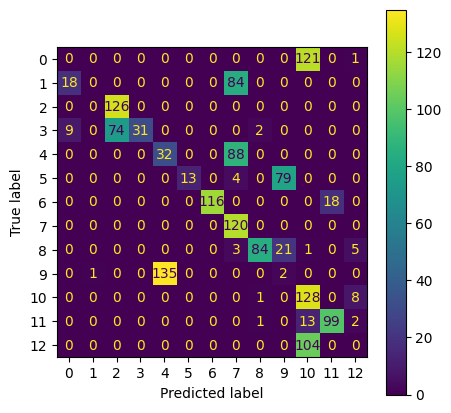

classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       122
           1       0.00      0.00      0.00       102
           2       0.63      1.00      0.77       126
           3       1.00      0.27      0.42       116
           4       0.19      0.27      0.22       120
           5       1.00      0.14      0.24        96
           6       1.00      0.87      0.93       134
           7       0.40      1.00      0.57       120
           8       0.95      0.74      0.83       114
           9       0.02      0.01      0.02       138
          10       0.35      0.93      0.51       137
          11       0.85      0.86      0.85       115
          12       0.00      0.00      0.00       104

    accuracy                           0.49      1544
   macro avg       0.49      0.47      0.41      1544
weighted avg       0.49      0.49      0.42      1544

***********************
SOME CLUSTERING METRICS
*********

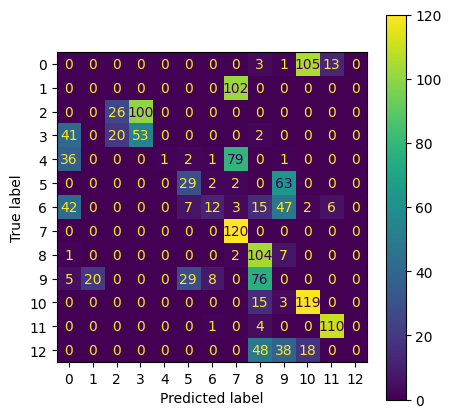

classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       122
           1       0.00      0.00      0.00       102
           2       0.57      0.21      0.30       126
           3       0.35      0.46      0.39       116
           4       1.00      0.01      0.02       120
           5       0.43      0.30      0.36        96
           6       0.50      0.09      0.15       134
           7       0.39      1.00      0.56       120
           8       0.39      0.91      0.55       114
           9       0.00      0.00      0.00       138
          10       0.49      0.87      0.62       137
          11       0.85      0.96      0.90       115
          12       0.00      0.00      0.00       104

    accuracy                           0.37      1544
   macro avg       0.38      0.37      0.30      1544
weighted avg       0.39      0.37      0.30      1544



/srv/public/Thibaud/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/srv/public/Thibaud/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/srv/public/Thibaud/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [78]:
anchors_ids = scenario3_anchors_ids
query_ids = scenario3_query_ids

re_id_report(anchors_ids, query_ids)
clustering_evaluation(anchors_ids, query_ids)
xgboost_evaluation(anchors_ids, query_ids)


# Other random visualisation ect

In [21]:
# For each class, gather the centroid from train data as an anchor
centroids = []

for dev in range(num_classes):
    ids_dev = np.where(np.array(encoded_labels) == dev)[0]
    class_encoded = np.array(encoded_data)[ids_dev]    
    centroids.append(class_encoded.mean(axis=0))

centroids = np.array(centroids)
print(centroids.shape)


(13, 384)


(77152, 384)
(77152, 13)
[21.69737639 22.32599694 22.54789891 21.96695215 21.65878216 21.58759186
 22.13592424 21.85455571 22.2904172  21.82616946 22.4019952  20.11614963
 21.98780937]


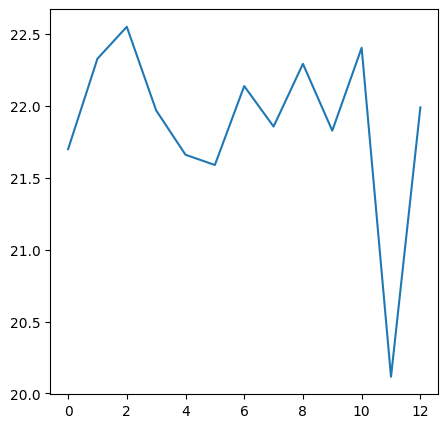

In [178]:
print(encoded_data.shape)
distances_centers = distance_matrix(encoded_data, centroids)
print(distances_centers.shape)
avg_ditance2center = np.mean(distances_centers, axis=0)
print(avg_ditance2center)
plt.plot(avg_ditance2center)
plt.show()

In [179]:
predicted_class = np.argmin(distances_centers, axis=1)
print(max(predicted_class))
print(max(encoded_labels[:, 0]))
print(predicted_class.shape)

12
12
(77152,)


confusion matrix
[[5336    1    0  133  228    2    0   19    2   16    0    1  105]
 [  38 5619   27    5   93   42    0  133    0    1    0    0    0]
 [   9    4 5673    1    9    0    0   57    1    7    0    1    0]
 [   4    1  160 5468   11    3   10   16   85    8   27   83   19]
 [ 164    4    1    2 5469   14   33   83    0  209    0    0    0]
 [ 186    5    5    2   41 5469  136    0   99   39    0   10    0]
 [   4    3    0    7    0   15 5776    4   13   92    0   16    0]
 [  41    6  101   53  126    0    2 5615   16  122    0    0    0]
 [  12   33    0   88    0   31   29    1 5754    3    1   35    9]
 [ 111   23   54    5  249   83   21   84    6 5249    0    6    0]
 [   0    0    0   12    0    5    0    0    5    0 5414    1  559]
 [  44  111 1025    2   40  873 1526    0  471   26  113 1365  367]
 [   0    0  101    2    0  336    0    0    0    0 2377   12 3037]]


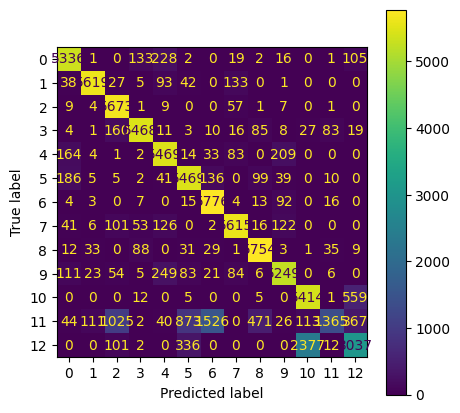

classification_report
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      5843
           1       0.97      0.94      0.95      5958
           2       0.79      0.98      0.88      5762
           3       0.95      0.93      0.94      5895
           4       0.87      0.91      0.89      5979
           5       0.80      0.91      0.85      5992
           6       0.77      0.97      0.86      5930
           7       0.93      0.92      0.93      6082
           8       0.89      0.96      0.92      5996
           9       0.91      0.89      0.90      5891
          10       0.68      0.90      0.78      5996
          11       0.89      0.23      0.36      5963
          12       0.74      0.52      0.61      5865

    accuracy                           0.85     77152
   macro avg       0.85      0.85      0.83     77152
weighted avg       0.85      0.85      0.83     77152

predicted clusters
(77152, 384)
(77152,)


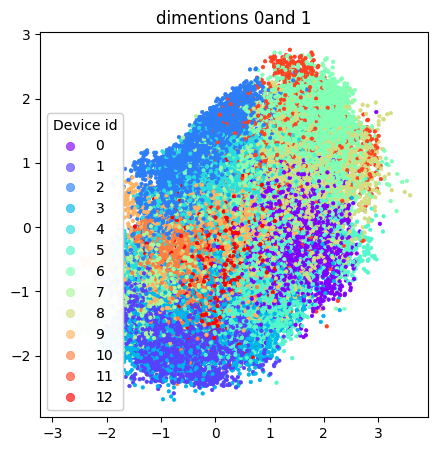

Ground truth labels
(77152, 384)
(77152,)


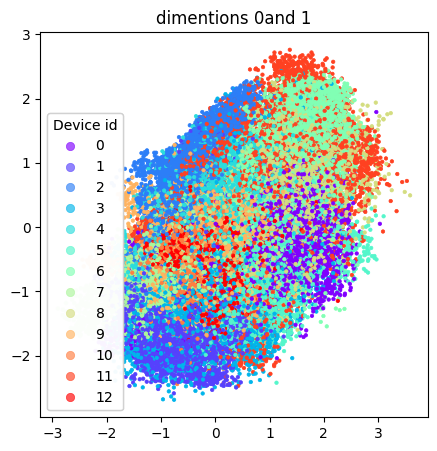

In [180]:
print('confusion matrix')
conf_mx =confusion_matrix(encoded_labels[:, 0], predicted_class)
print(conf_mx)

# Confusion Matrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                              display_labels=range(num_classes))
disp.plot()
plt.show()


print('classification_report')
print(classification_report(encoded_labels[:, 0], predicted_class))


print("predicted clusters")
scatter_plot(np.array(encoded_data), np.array(predicted_class))
plt.show()

print("Ground truth labels")
scatter_plot(np.array(encoded_data), np.array(encoded_labels[:, 0]))
plt.show()

In [181]:
# Check miss classification in 2D
T_SNE_test = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=10).fit_transform(np.array(encoded_data))

(77152, 2)
(77152,)
(77152, 2)
(77152,)


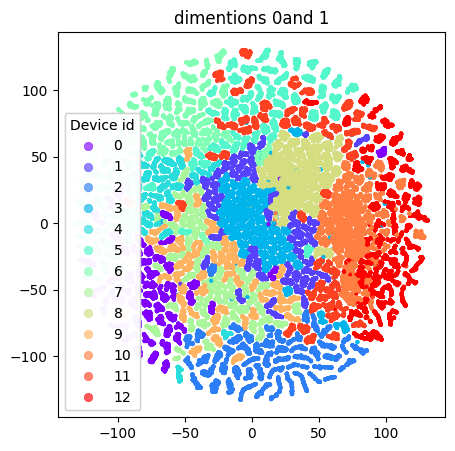

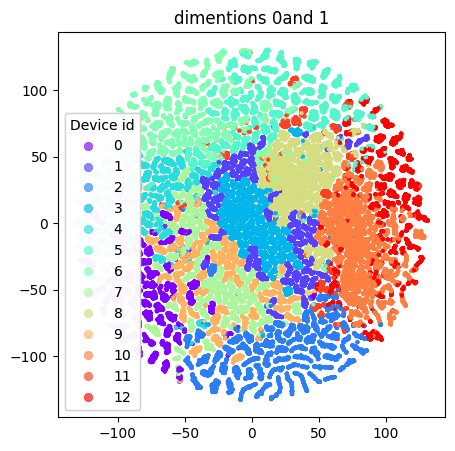

In [ ]:
scatter_plot(T_SNE_test, encoded_labels[:, 0])
scatter_plot(T_SNE_test, predicted_class)
plt.show()


# Use other types of classification

In [30]:
import xgboost as xgb 

In [31]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42) #"multi:softprob" #'binary:logistic' multi:softmax

xgb_model.fit(encoded_train, labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

confusion matrix
[[ 341    0    0    8    8   82   37  154  415]
 [  43   12    0    0  123    0    0   43  854]
 [   0 1084    0    2    2    0    0    0    4]
 [   0    0    1  747    0    0    0    0  270]
 [   0    0  399    0  526    0    0   60   96]
 [   0    0    0    0    0   95  360    0  546]
 [   0    0    0   19    0    0  440    0  566]
 [   1    0    0  367   95    0    0    0  596]
 [   0   16    0    0   44    0   16    0  993]]


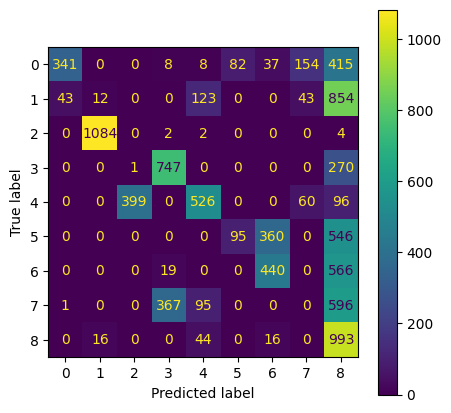

classification_report
              precision    recall  f1-score   support

           0       0.89      0.33      0.48      1045
           1       0.01      0.01      0.01      1075
           2       0.00      0.00      0.00      1092
           3       0.65      0.73      0.69      1018
           4       0.66      0.49      0.56      1081
           5       0.54      0.09      0.16      1001
           6       0.52      0.43      0.47      1025
           7       0.00      0.00      0.00      1059
           8       0.23      0.93      0.37      1069

    accuracy                           0.33      9465
   macro avg       0.39      0.33      0.30      9465
weighted avg       0.38      0.33      0.30      9465



In [32]:
predicted_class = xgb_model.predict(encoded_test)

print('confusion matrix')
conf_mx =confusion_matrix(labels_test, predicted_class)
print(conf_mx)

# Confusion Matrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mx,
                              display_labels=range(num_classes+1))
disp.plot()
plt.show()


print('classification_report')
print(classification_report(labels_test, predicted_class))

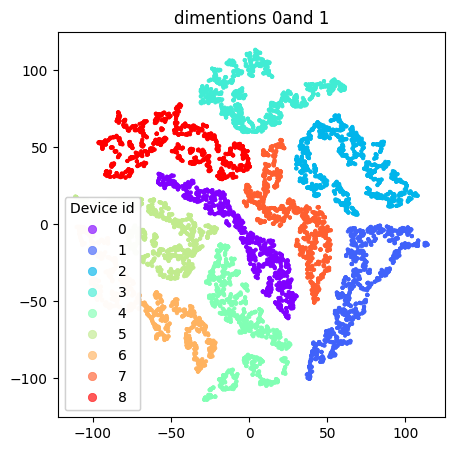

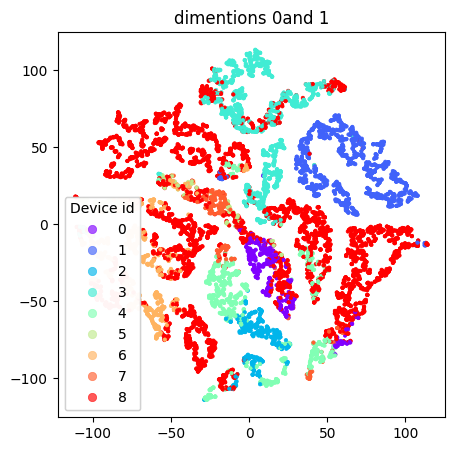

In [33]:
scatter_plot(T_SNE_test, labels_test)
scatter_plot(T_SNE_test, predicted_class)
plt.show()
